# KAGGLE TITANIC CHALLENGE
https://www.kaggle.com/c/titanic
## SUMMARY
Here is my attempt to crack the Kaggle Titanic challenge. For those who don't know : it is a machine learning prediction case study in which to goal is to predict and guess who would die or survive in the Titanic accident, using data about the passengers (age, sex, cabin, etc..).

I used Python, Pandas, Scikit-Learn and a little bit of TensorFlow

In the menu : 
- Loading the datasets
- Exploratory analysis and correlations between variables and the chances of survival
- First preprocessing model (feature engineering, one-hot encoding, normalization)
- Selection of the best classifier : Random Forest ensemble classifier
- Optimization and hyper-parameters tuning for this classifier 
- Quick deep learning classifier test with TensorFlow on the data


Will follow :  
- Advanced feature engineering
- Advanced deep learning methods (regularization especially to reduce overfitting)

***

##### Loading the datasets
Import the train and test datasets on your computer from the Kaggle website

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print train.shape
print test.shape

(891, 12)
(418, 11)


## Exploratory analysis
### What is going here ?

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We have some missing data, a lot for Cabin, and some for Age and Embarked, yet we'll deal with them later 

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Which features are we going to consider ?

In [6]:
target = "Survived"
features = [x for x in list(test.columns) if x not in ['PassengerId']]
print(features)

['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


Let's take a look at the data

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Study of each features
There are 10 features to consider in the dataset.
- 2 are text variables, Name and ticket 
- 3 are numeric variables (ticket fare, passenger age, number of siblings embarked with)
- the others are categorical features

##### Passenger class

We have 891 passengers in the dataset. 

Each are separated in 3 passenger class, the class 3 contains half of the passengers

Let's build a function to find the number of passengers by unique values, and if they have survived or not. 

It will allow us to understand the correlation of survival along one independent variable. 

In [8]:
def distribution_by_unique_values(feature):
    _ = pd.DataFrame()
    temp = train.groupby([feature])
    _['count'] = temp.count()['PassengerId']
    _['survived'] = temp.sum()['Survived']
    _['dead'] = _['count'] - _['survived']
    _['percentage'] = _['count']/sum(_['count'])
    _['percentage died'] = _['dead']/_['count']
    return _

distribution_by_unique_values('Pclass')

,count,survived,dead,percentage,percentage died
Pclass,,,,,
1,216,136,80,0.242424,0.370370
2,184,87,97,0.206510,0.527174
3,491,119,372,0.551066,0.757637



To that extent, let's build also a function to plot a bar diagram showing the survival by unique occurence of a variable

In [9]:
def plot_distribution(feature):
    title = 'Number of passengers by %s' % feature
    distribution = distribution_by_unique_values(feature)
    indexes = [i for i in range(len(list(distribution.index)))]
    distribution[['survived','dead']].plot(kind = "bar",stacked = True,title = title,figsize = (15,5))
    plt.xticks(indexes,list(distribution.index))
    plt.show()

We can already observe some "nice" correlations : 
- Passengers in class 1 are more likely to survive
- Passengers in class 2 50% of chances 
- Passengers in class 3 are outstandingly more likely to die

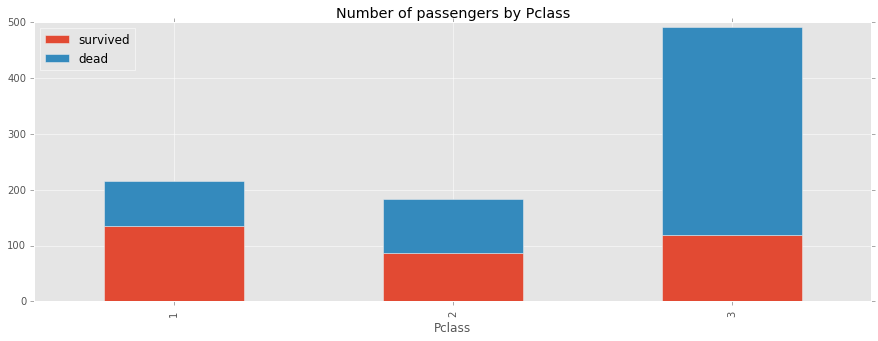

In [10]:
plot_distribution('Pclass')

##### Passenger Sex
A lot more men are travelling, however the survival rate is much higher for women. 

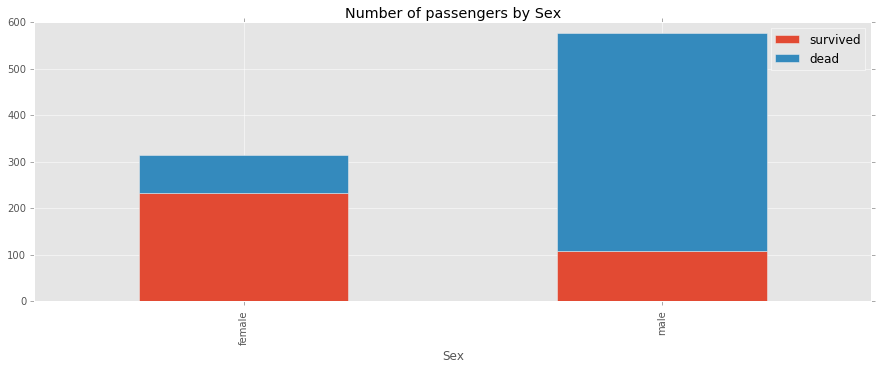

In [11]:
plot_distribution('Sex')

##### Passenger Age

That variable is numerical, let's build another function to plot an histogram showing the chances of survival : 

In [12]:
def plot_histogram(feature):
    plt.figure(figsize = (15,5))
    plt.title('Distribution of %s' % feature)
    temp = train.copy()
    temp[feature].fillna(temp[feature].median(),inplace = True)
    plt.hist([temp[temp['Survived'] == 1][feature],temp[temp['Survived'] == 0][feature]],stacked = True,bins = 30,label = ['Survived','Dead'])
    plt.xlabel(feature)
    plt.ylabel('Number of passengers')
    plt.show()

Most passengers are young people from 20 to 30, about 50% 

There are about 100 children and teens. And only about 10% of people aged more than 55

Young and old people seem more likely to survive.

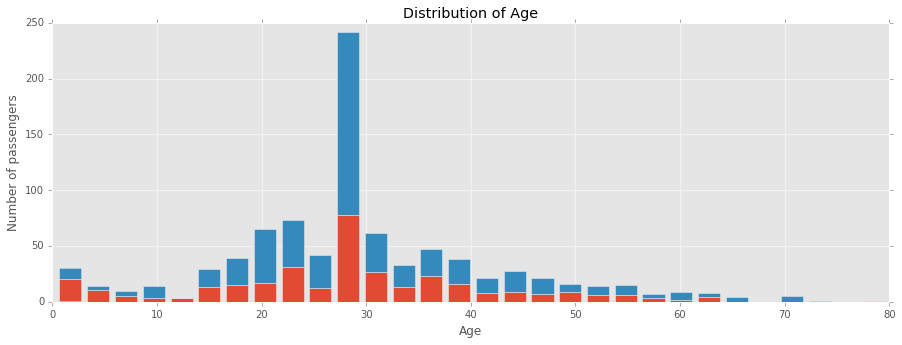

In [13]:
plot_histogram('Age')

##### Siblings embarked
This feature is important, because we can imagine that large families are more likely to be travelling in a cheaper situation, thus making them less likely to be saved.
- Most passengers travel alone (70%).
- 23% travel with one person
- A few (and probably one only) big families with eight siblings


And, we can observe that people travelling alone or with big families are more likely to die. 

In [14]:
distribution_by_unique_values('SibSp')

,count,survived,dead,percentage,percentage died
SibSp,,,,,
0,608,210,398,0.682379,0.654605
1,209,112,97,0.234568,0.464115
2,28,13,15,0.031425,0.535714
3,16,4,12,0.017957,0.750000
4,18,3,15,0.020202,0.833333
5,5,0,5,0.005612,1.000000
8,7,0,7,0.007856,1.000000


##### Parch
Parch is number of parents travelling with a passenger. 

We can make the same observations as for the siblings : middle sized families are more likely to survive. 

In [15]:
distribution_by_unique_values('Parch')

,count,survived,dead,percentage,percentage died
Parch,,,,,
0,678,233,445,0.760943,0.656342
1,118,65,53,0.132435,0.449153
2,80,40,40,0.089787,0.500000
3,5,3,2,0.005612,0.400000
4,4,0,4,0.004489,1.000000
5,5,1,4,0.005612,0.800000
6,1,0,1,0.001122,1.000000


##### Ticket fare
Again this is a probably import feature, if we assume that rich passengers are more likely to survive. 

Most people paid a really low price, while a few paid 10 times the low price ticket

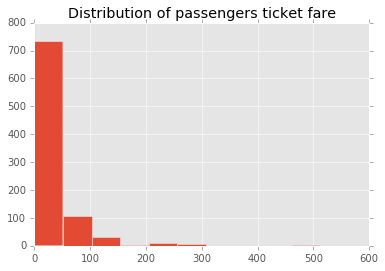

In [16]:
plt.title('Distribution of passengers ticket fare')
train['Fare'].hist(bins = 10)
plt.show()

##### Cabin Number
Cabin number will be a less important feature in the first models. We can probably extract information about where are located the cabins. 

Some assumptions : 
- Cabins with the same letter have the same standing, hosting categories of people with similar survival probabilities
- Some cabins are probably located closer from the safety boats
- Number can indicate in which floor the cabin is situated. On the top floor you take more time to reach the safety boats. 

We noticed also 

In [17]:
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

##### Embarked

Embarked is where people have embarked on the boat. This can be correlated to the location of the cabin and thus if they would survive or not. 

Indeed, people who have embarked at C are substantially more likely to survive. 

The S embarkation looks like the cheapest one, with the most people and only 33% chances to survive VS 55% for C

In [18]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [19]:
distribution_by_unique_values('Embarked')

,count,survived,dead,percentage,percentage died
Embarked,,,,,
C,168,93,75,0.188976,0.446429
Q,77,30,47,0.086614,0.610390
S,644,217,427,0.724409,0.663043


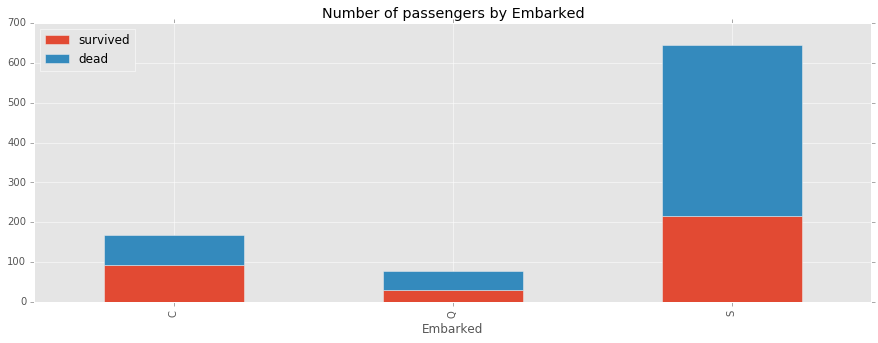

In [20]:
plot_distribution('Embarked')

##### Survived

Of course we have to take a quick look at the survival data. 

61% have died in the collision

In [21]:
temp = pd.DataFrame()
temp['count'] = train.groupby('Survived').count()['PassengerId']
temp['%'] = temp['count']/sum(temp['count'])
temp

,count,%
Survived,,
0,549,0.616162
1,342,0.383838


##### Conclusion
Let's draw some observations of the first exploratory analysis. 
- We discovered the data and the features
- We observed the distribution of each features. 
- We found some correlations between variables (cabin, sex, age, size of the group travelling) with survival

In the future, while processing the data, we will build more interesting features with the name and the cabin. 
But still, let's start with that to see the impact of each improvement on the accuracy. 

***
## FIRST FEATURE ENGINEERING MODEL
I want to separate the feature engineering from the algorithm accuracy. So at first, we will tune a model only with the data previously seen. 

Let's take a look again at the data

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### We will only keep the following features for now : 
- Pclass
- Sex
- Age
- SibSp
- Parch
- Fare
- Embarked



##### The first preprocessing will hold these steps: 
- Keep the above features
- Clean the missing data with simply the median for the Age and Fare and the most frequent category for Embarked (S)
- Engineer the feature "GroupSize" from "SibSp" and "Parch"
- For each categorical variable, create one-hot-encoding (boolean) features
- Normalize every feature to facilitate the optimization

In [23]:
def preprocessing_first(normalization = True):
    '''
    FIRST PREPROCESSING MODEL FOR TITANIC DATA
    '''
    global train
    global test  
    
    print('>> Preprocessing the data ...')
    print('')
    
    target = ['Survived']
    features = ['Pclass','Sex','SibSp','Parch','Embarked','Fare','Age']
    
    '''COMBINING THE DATA TO PREPROCESS'''
    print("- Combining")
    data = train[features].append(test[features],ignore_index = True).copy()
    
    
    '''FILLING MISSING DATA : filling "Age" and "Fare" with the median, and "Embarked" with "S" '''
    print("- Filling missing data")
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Embarked'] = data['Embarked'].fillna("S")
        
        
    '''SAFETY CHECK FOR MISSING DATA'''
    test_missing_data = data.isnull().sum()
    if test_missing_data.sum() > 0:
        missing_features = list(test_missing_data[test_missing_data != 0].index)
        raise ValueError("Unable to process because of remaining missing data : %s " % missing_features)
    else:
        print("  ... No missing data")
    
    
    '''FEATURE ENGINEERING'''
    print('- Feature engineering')
    #CREATING THE GROUPSIZE FEATURE
    print('  ... Group Size')
    data['Groupsize'] = data['SibSp']+data['Parch']
    data.drop(['SibSp','Parch'],axis = 1,inplace = True)
    
    
    '''ONE HOT ENCODING'''
    print("- One Hot Encoding")
    cat_features = ['Pclass','Sex','Embarked']
    for feature in cat_features:
        onehot = pd.get_dummies(data[feature],prefix = feature)
        data = pd.concat([data,onehot],axis = 1)
        data.drop(feature,axis = 1,inplace = True)
    
    '''NORMALIZATION'''
    if normalization:
        print('- Normalization')
        for feature in data.columns:
            mean = data[feature].mean()
            std = data[feature].std()
            data[feature] = data[feature].map(lambda x : (x-mean)/std)
    
    '''EXTRACTING THE PREPROCESSED TRAIN AND TEST DATA FROM THE COMBINED DATA'''
    print('- Extracting the train and test set')
    data_train,data_test = data.ix[:len(train)-1].copy(),data.ix[len(train):].reset_index(drop=True).copy()
    data_train['Survived'] = train['Survived']
    
    print('')
    print(">> Preprocessing the data OK")
    return data_train,data_test


In [24]:
data_train,data_test = preprocessing_first()

>> Preprocessing the data ...

- Combining
- Filling missing data
  ... No missing data
- Feature engineering
  ... Group Size
- One Hot Encoding
- Normalization
- Extracting the train and test set

>> Preprocessing the data OK


##### We now have a first version of our processed and cleaned dataset on which we can perform machine learning predictions

In [25]:
data_train.head()

,Fare,Age,Groupsize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,-0.503099,-0.581406,0.073324,-0.572133,-0.517886,0.919574,-0.743213,0.743213,-0.509575,-0.321917,0.654761,0
1,0.734463,0.658400,0.073324,1.746511,-0.517886,-1.086630,1.344482,-1.344482,1.960920,-0.321917,-1.526109,1
2,-0.490053,-0.271455,-0.558133,-0.572133,-0.517886,0.919574,1.344482,-1.344482,-0.509575,-0.321917,0.654761,1
3,0.383037,0.425937,0.073324,1.746511,-0.517886,-1.086630,1.344482,-1.344482,-0.509575,-0.321917,0.654761,1
4,-0.487637,0.425937,-0.558133,-0.572133,-0.517886,0.919574,-0.743213,0.743213,-0.509575,-0.321917,0.654761,0


In [26]:
data_test.head()

,Fare,Age,Groupsize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.491905,0.387193,-0.558133,-0.572133,-0.517886,0.919574,-0.743213,0.743213,-0.509575,3.104015,-1.526109
1,-0.507930,1.355791,0.073324,-0.572133,-0.517886,0.919574,1.344482,-1.344482,-0.509575,-0.321917,0.654761
2,-0.455990,2.518110,-0.558133,-0.572133,1.929452,-1.086630,-0.743213,0.743213,-0.509575,3.104015,-1.526109
3,-0.475800,-0.193967,-0.558133,-0.572133,-0.517886,0.919574,-0.743213,0.743213,-0.509575,-0.321917,0.654761
4,-0.405740,-0.581406,0.704781,-0.572133,-0.517886,0.919574,1.344482,-1.344482,-0.509575,-0.321917,0.654761


***
## First Machine Learning model

#### Classifiers
We are going to try the following machine learning classifiers encompassing regression to ensemble classifiers

In [27]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLASSIFIER
classifiers = [
    ('Naive Bayes Multinomial',naive_bayes.MultinomialNB(fit_prior = True)),
    ('Naive Bayes Gaussian',naive_bayes.GaussianNB()),
    ('Logistic Regression',LogisticRegression()),
    ('Linear SVC',LinearSVC(C=1.0)),
    ('Random Forest',RandomForestClassifier(n_estimators=30,min_samples_leaf = 1,min_samples_split = 10)),
    ('Gradient Boosting',GradientBoostingClassifier(random_state=1, n_estimators=50, max_depth=30)),
    ('KNeighbors',KNeighborsClassifier()),
    ('SVC',SVC(gamma=2, C=1)),
    ('Decision Tree',DecisionTreeClassifier()),
]

We are going to need to perform cross validation to assess the validity of our classifiers. 

For that we are going to use the following function :

In [8]:
from sklearn.cross_validation import cross_val_score

def cross_validation_score(clf,training_set,n_folds = 5,return_score = False):
    X,y = training_set.iloc[:,:-1],training_set.iloc[:,-1]
    scores = list(cross_val_score(clf,X,y,cv = n_folds))
    scores = sum(scores)/len(scores)
    print("- Cross validation score of %s" % scores)
    if return_score:
        return scores

#### First test with all the classifiers
Every classifier achieve a cross validation score of about 80% : 

The bests without tuning any hyperparameters seem to be Random Forest and SVM

(NB : the Multinomial Naive Bayes does not work with negative numbers) 

In [29]:
for classifier in classifiers:
    try:
        print('Testing %s ' % classifier[0])
        cross_validation_score(classifier[1],data_train)
        print('')
    except:
        print('- PROBLEM')
        print('')
        pass

Testing Naive Bayes Multinomial 
- PROBLEM

Testing Naive Bayes Gaussian 
- Cross validation score of 0.789081834905

Testing Logistic Regression 
- Cross validation score of 0.79355132143

Testing Linear SVC 
- Cross validation score of 0.799125288541

Testing Random Forest 
- Cross validation score of 0.828364234604

Testing Gradient Boosting 
- Cross validation score of 0.784562202748

Testing KNeighbors 
- Cross validation score of 0.804736563435

Testing SVC 
- Cross validation score of 0.781191345304

Testing Decision Tree 
- Cross validation score of 0.777801585723



#### First submission to Kaggle
Let's build the Kaggle submission with the Random Forest classifier

In [102]:
random_forest = classifiers[4][1]

def prediction(clf,training_set,test_set):
    X,y = training_set.iloc[:,:-1],training_set.iloc[:,-1]
    clf.fit(X,y)
    pred = pd.DataFrame()
    pred['PassengerId'] = test['PassengerId']
    pred['Survived'] = clf.predict(test_set)
    return pred

first_prediction = prediction(random_forest,data_train,data_test)
first_prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [31]:
first_prediction.to_csv('submission.csv',delimiter = ",",index=False)

With this submission, I was able to achieve 77% accuracy on the public leaderboard. 

And ranked 3000/4800 teams

#### Parameter tuning with Random Forest
Let's run a grid search to optimize the hyperparameters. 

With Random Forests, we will then keep :
- n_estimators = 30
- min_samples_leaf = 1
- min_samples_split = 2
- max_depth = 9
- criterion = gini

(NB : the cross val score does not change much, tuning here is probably not going to be a deal changer to crack this case)

In [9]:
def split_train(training_set):
    X,y = training_set.iloc[:,:-1],training_set.iloc[:,-1]
    return X,y

In [41]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

X,y = split_train(data_train)
random_forest_tuned = RandomForestClassifier()
cross_validation = StratifiedKFold(y, n_folds=5)
print('SEARCHING ...')
parameter_grid = {
                 'min_samples_leaf':[1,2,5,10],
                 'min_samples_split':[1,2,5,10],
                 'max_depth' : [4,5,6,7,8,9,10,None],
                 'n_estimators': [10,30,80,150,250],
                 'criterion': ['gini','entropy']
                 }

grid_search = GridSearchCV(random_forest_tuned,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X,y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


SEARCHING ...
Best score: 0.835016835017
Best parameters: {'min_samples_split': 1, 'n_estimators': 30, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2}


Let's try again another submission with the tuned parameters and see if it increases our score on Kaggle

In [30]:
random_forest_tuned = RandomForestClassifier(n_estimators = 30,\
                                             min_samples_split = 1,\
                                             min_samples_leaf = 2,\
                                             criterion = "gini",\
                                             max_depth = 9)

prediction_tuned = prediction(random_forest_tuned,data_train,data_test)
prediction_tuned.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [14]:
prediction_tuned.to_csv('submission_tuned.csv',delimiter = ",",index=False)

#### Quick deep learning digression

Here and with the simple data model, I wanted to see the performance of a Deep Neural Network on the problem. 

For ease of implementation, I used skflow, a scikit-learn-like package of the deep learning library TensorFlow, developed by Google : 

https://www.tensorflow.org/

https://github.com/tensorflow/skflow

I trained a 4 layers Neural Network on the data, which helped my to achieve a little better score on the Kaggle Dashboard : 
- 78% accuracy on the secret dataset
- ranking better of about 500 : now ranked 2500/4800

Yet, I am not convinced of the validity of using a Deep Learning model here with that few data, but in a way this problem is a matter how well you succeed to overfit the test data, so why not ? 

In [21]:
import tensorflow.contrib.learn as skflow
X,y = split_train(data_train)
model = skflow.TensorFlowDNNClassifier(hidden_units=[100,200,200,100], n_classes=2, steps=1500)
model.fit(X, y)

TensorFlowDNNClassifier(steps=1500, batch_size=32)

In [24]:
pred_tensorflow = model.predict(data_test)
output_tensorflow = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred_tensorflow})
output_tensorflow.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [25]:
output_tensorflow.to_csv('submission_tensorflow.csv',delimiter = ",",index=False)

***
## SECOND FEATURE ENGINEERING MODEL

In this second pass, we will complete our feature engineering with studying the Name field which: 
1. will give information about the status of the passenger
2. will infer better filling of the ages 

#### Study of the name
To be sure we won't forget anyone here, like in the first feature engineering pass, we will combine the two datasets to study the names.

In [10]:
combined = train[[x for x in list(train.columns) if x != "Survived"]].append(test[features],ignore_index = True).copy()
combined.shape

(1309, 11)

We can find a very useful information in the name of the passengers : the status. 

Here for the first 5, we can observe Mr. and Mrs. but we'll see there are a lot more. 

Thankfully, every name is formatted the same way, with the status after ", " et before the point ".". So we can extract it !

In [11]:
combined['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [12]:
def extract_status(name):
    s = name.find(", ")
    e = s+2+name[s+2:].find(".")
    return name[s+2:e+1]

In [13]:
extract_status(combined['Name'][0])

'Mr.'

Let's try that on the full data set to understand better. 

In [14]:
combined['Status'] = combined['Name'].map(extract_status)
combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Status
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1.0,3,male,1,A/5 21171,Mr.
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,female,1,PC 17599,Mrs.
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3.0,3,female,0,STON/O2. 3101282,Miss.
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4.0,1,female,1,113803,Mrs.
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5.0,3,male,0,373450,Mr.


We then get a precious new information we did not have before : 

In [15]:
combined['Status'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'the Countess.', 'Jonkheer.', 'Dona.'], dtype=object)

What's great is that there is no data missing here, so we will be able to infer new data thanks to that, especially for the ages ! 

In [16]:
sum(combined['Status'].isnull())

0

Then we will use the following table providing the median age by status and sex to more accurately fill the ages in the data preprocessing step : 

In [17]:
mapping_ages = combined.groupby(['Status','Sex'],as_index = False).aggregate({"Age":pd.Series.median,"PassengerId":pd.Series.count})
mapping_ages

,Status,Sex,Age,PassengerId
0,Capt.,male,70.0,1.0
1,Col.,male,54.5,2.0
2,Don.,male,40.0,1.0
3,Dona.,female,39.0,0.0
4,Dr.,female,49.0,1.0
5,Dr.,male,47.0,6.0
6,Jonkheer.,male,38.0,1.0
7,Lady.,female,48.0,1.0
8,Major.,male,48.5,2.0
9,Master.,male,4.0,40.0


For the purpose of filling the age, we need a more complex function : 

In [18]:
def fill_ages(row):
    '''Used with the apply methode we pass a dataframe row as a parameter
       The function looks up in the above table to find a better approximation of the missing age of a passenger
    '''
    if np.isnan(row['Age']):
        return mapping_ages[(mapping_ages['Status'] == row['Status'])&(mapping_ages['Sex'] == row['Sex'])]['Age'].iloc[0]
    else:
        return row['Age']

Let's implement that function in our preprocessing pass. 

We will also add the cabin feature by taking the first letter of the cabin field (and "M" for the missing data)

In [19]:
def preprocessing_second(normalization = True):
    '''
    FIRST PREPROCESSING MODEL FOR TITANIC DATA
    '''
    global train
    global test
    global mapping_ages
    
    print('>> Preprocessing the data ...')
    print('')
    
    target = ['Survived']
    features = ['Pclass','Sex','SibSp','Parch','Embarked','Fare','Age','Name','Cabin'] # Name and cabin features added compared to the first model
    
    '''COMBINING THE DATA TO PREPROCESS'''
    print("- Combining")
    data = train[features].append(test[features],ignore_index = True).copy()
    
    '''FEATURE ENGINEERING FIRST PASS : creating the status feature'''
    data['Status'] = combined['Name'].map(extract_status)
    data = data.drop('Name',axis = 1)
    
    '''FILLING MISSING DATA : filling "Age" and "Fare" with the median, and "Embarked" with "S" '''
    print("- Filling missing data")
    
    #A little bit more complicated for the Ages
    data['Age'] = data.apply(fill_ages,axis = 1)
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Embarked'] = data['Embarked'].fillna("S")
    data['Cabin'] = data['Cabin'].fillna("M").map(lambda x :x[0])        
        
    '''SAFETY CHECK FOR MISSING DATA'''
    test_missing_data = data.isnull().sum()
    if test_missing_data.sum() > 0:
        missing_features = list(test_missing_data[test_missing_data != 0].index)
        raise ValueError("Unable to process because of remaining missing data : %s " % missing_features)
    else:
        print("  ... No missing data")
    
    
    '''FEATURE ENGINEERING'''
    print('- Feature engineering')
    #CREATING THE GROUPSIZE FEATURE
    print('  ... Group Size')
    data['Groupsize'] = data['SibSp']+data['Parch']
    data = data.drop(['SibSp','Parch'],axis = 1)
    

    
    '''ONE HOT ENCODING'''
    print("- One Hot Encoding")
    cat_features = ['Pclass','Sex','Embarked','Status','Cabin']
    for feature in cat_features:
        onehot = pd.get_dummies(data[feature],prefix = feature)
        data = pd.concat([data,onehot],axis = 1)
        data.drop(feature,axis = 1,inplace = True)
    
    '''NORMALIZATION'''
    if normalization:
        print('- Normalization')
        for feature in data.columns:
            mean = data[feature].mean()
            std = data[feature].std()
            data[feature] = data[feature].map(lambda x : (x-mean)/std)
    
    '''EXTRACTING THE PREPROCESSED TRAIN AND TEST DATA FROM THE COMBINED DATA'''
    print('- Extracting the train and test set')
    data_train,data_test = data.ix[:len(train)-1].copy(),data.ix[len(train):].reset_index(drop=True).copy()
    data_train['Survived'] = train['Survived']
    
    print('')
    print(">> Preprocessing the data OK")
    return data_train,data_test


In [20]:
data_train,data_test = preprocessing_second()

>> Preprocessing the data ...

- Combining
- Filling missing data
  ... No missing data
- Feature engineering
  ... Group Size
- One Hot Encoding
- Normalization
- Extracting the train and test set

>> Preprocessing the data OK


### Feature selection
First I tested the model without adding the Cabin feature, and it gave me a better score than afterwards.

We now have probably too many features and a little bit of overfitting. 

Sometimes in that situation it may be smart to reduce the number of features used in the model. 

For that we can compute the feature importance with decision trees and take the top important ones : 

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

X,y = data_train.iloc[:,:-1],data_train.iloc[:,-1]
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X,y)
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features = features.sort_values(['importance'],ascending=False)
features

,feature,importance
0,Fare,0.205772
1,Age,0.195657
23,Status_Mr.,0.109249
6,Sex_female,0.087643
7,Sex_male,0.074936
2,Groupsize,0.065513
5,Pclass_3,0.047985
36,Cabin_M,0.031766
20,Status_Miss.,0.024872
24,Status_Mrs.,0.023775


Then we can only take the top 15 features for the prediction

In [23]:
top15_features = list(features["feature"].iloc[:15])
top15_features

['Fare',
 'Age',
 'Status_Mr.',
 'Sex_female',
 'Sex_male',
 'Groupsize',
 'Pclass_3',
 'Cabin_M',
 'Status_Miss.',
 'Status_Mrs.',
 'Pclass_1',
 'Pclass_2',
 'Status_Master.',
 'Embarked_S',
 'Embarked_C']

However, it seems to work better without the cabin feature we will take out

In [24]:
new_features = list(features[features['feature'].map(lambda x : 'Cabin' not in x)]['feature'])
new_features

['Fare',
 'Age',
 'Status_Mr.',
 'Sex_female',
 'Sex_male',
 'Groupsize',
 'Pclass_3',
 'Status_Miss.',
 'Status_Mrs.',
 'Pclass_1',
 'Pclass_2',
 'Status_Master.',
 'Embarked_S',
 'Embarked_C',
 'Embarked_Q',
 'Status_Rev.',
 'Status_Dr.',
 'Status_Major.',
 'Status_Col.',
 'Status_Capt.',
 'Status_Don.',
 'Status_Sir.',
 'Status_Jonkheer.',
 'Status_Ms.',
 'Status_Mlle.',
 'Status_Lady.',
 'Status_the Countess.',
 'Status_Mme.',
 'Status_Dona.']

### Prediction with Random Forests

We will use the Random Forests previously tuned to predict the survival of the passengers.

In [141]:
random_forest = RandomForestClassifier(n_estimators = 30,\
                                             min_samples_split = 1,\
                                             min_samples_leaf = 2,\
                                             criterion = "gini",\
                                             max_depth = 9)

new_prediction = prediction(random_forest,data_train[new_features+['Survived']],data_test[new_features])
new_prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Let's submit again with those results ! 

In [142]:
new_prediction.to_csv('new_prediction.csv',delimiter = ",",index=False)

I was able to achieve a 79% score with this submission, thus ranking me 1500th 

### Tensorflow again,
It does not work as well as before, eventually I will try better deep learning models here. 

In [ ]:
import tensorflow.contrib.learn as skflow
X,y = split_train(data_train[new_features+['Survived']])
model = skflow.TensorFlowDNNClassifier(hidden_units=[300,300,300,200], n_classes=2, steps=15000)
model.fit(X, y)

In [ ]:
pred_tensorflow = model.predict(data_test[new_features])
output_tensorflow = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred_tensorflow})
output_tensorflow.head()

In [ ]:
output_tensorflow.to_csv('submission_tensorflow.csv',delimiter = ",",index=False)